# Pokémon Changes Through the Generations


In [114]:
import kagglehub

# Using the Kaggle API requires a token including a username and key
kagglehub.login() 

# KAGGLE_USERNAME=fluenenittini
# KAGGLE_KEY=32922ee58f8623fbef759e86ee944449

In [115]:
import csv
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download CVS data file from Kaggle and saving the download path to be used later
dataset_path = kagglehub.dataset_download('rounakbanik/pokemon', path='pokemon.csv')

# Can also use the CVS data file included in this repository by uncommenting the line bellow in the notebook
# dataset_path = 'pokemon.csv'


In [ ]:
# Initialize dictionary for generations
gen_weights = {str(i): [] for i in range(1, 8)}

# Read CSV and populate generation lists with the weights and respective generation
with open(dataset_path, newline='') as data:
    reader = csv.DictReader(data)
    for row in reader:
        gen = row['generation']
        if gen in gen_weights and row['weight_kg']:
            gen_weights[gen].append(float(row['weight_kg']))




## Scatter Plot of all Weights

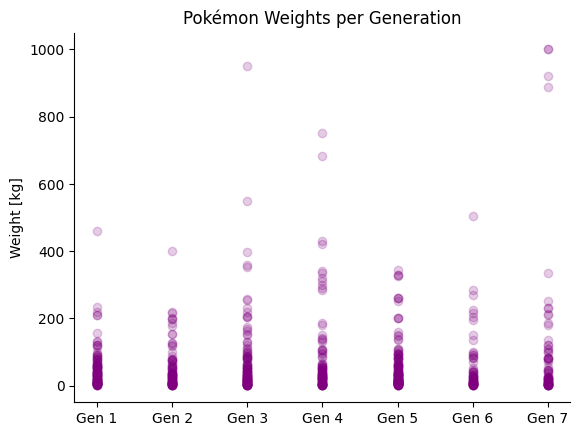

In [ ]:
for i in range(1, 8):
    plt.scatter([f'Gen {i}' for j in range(len(gen_weights[str(i)]))], gen_weights[str(i)], color="purple", alpha=0.2) 
    

# Some custumization 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel("Weight [kg]")
plt.title("Pokémon Weights per Generation")

# plt.legend()
plt.show()

Based on the plot above, it seems like Gen 7 has some heavier Pokémon compared to the other generations. In addition Gen 3 has a heavy one.

## Bar Plot Showing the Average Weights

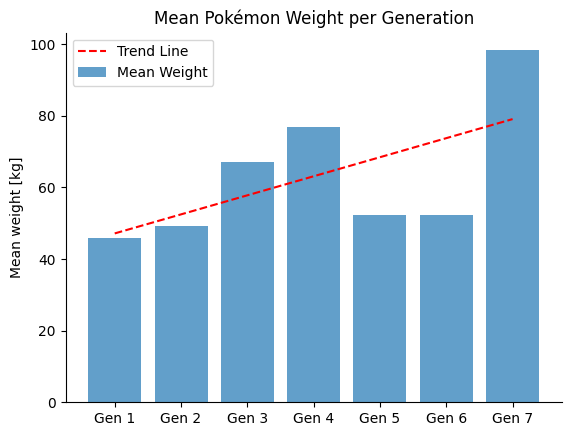

In [ ]:
# Function to compute mean
def find_mean(lst):
    if len(lst) != 0:
        return sum(lst) / len(lst)
    else:
        return 0

# Function to compute standard deviation
def find_stdev(lst):
    if len(lst) != 0:
        mean = find_mean(lst)
        variance = sum((x - mean) ** 2 for x in lst) / len(lst)
        return np.sqrt(variance)
    else:
        return 0

# Compute mean weights and standars deviations of the different generations
x_vals = np.arange(1, 8)
means  = [find_mean(gen_weights[str(i)]) for i in range(1, 8)]
stdevs   = [find_stdev(gen_weights[str(i)]) for i in range(1, 8)]

# Fit a linear trend line
coeffs = np.polyfit(x_vals, means, 1)  # Find a fitting linear polynomial and return the coefficients
trend_line = np.poly1d(coeffs)  # Create the polynomial function

# Create x and y values for the plotting of the trend line
x_trend = np.linspace(1, 7, 100)
y_trend = trend_line(x_trend)

# Plot trend line
plt.plot(x_trend, y_trend, color='red', linestyle='--', label="Trend Line")

# Create bar plot of the avg. weights 
plt.bar(x_vals, means, tick_label=[f'Gen {i}' for i in range(1, 8)], alpha=0.7, label="Mean Weight")

# Plot errorbars using the standard deviation
# plt.errorbar(x_vals, means, yerr=stdevs, fmt='o', capsize=5, capthick=2, elinewidth=1, color="gray", label="Standard deviation")

# Labels and title
plt.ylabel("Mean weight [kg]")
plt.title("Mean Pokémon Weight per Generation")

# Some custumization 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()







Based on the average weights, it seems like the total trend is that the Pokémon are getting heavier, however, Gens 5 and 6, has an average weight more similar to Gens 1 and 2. The standard deviation for these means can be showed by uncommenting the plt.errorbar line in the notebook, however, it is left oft, as the standard deviation is very large and thus uninformative.

## Bar Plot of the Median Weights

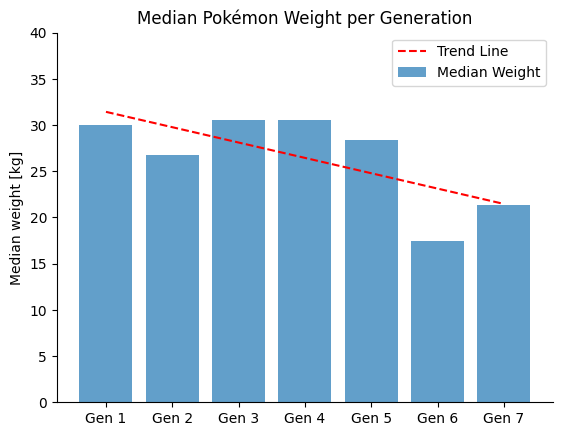

In [120]:
# Calculate the median value depending on wheather the list is odd or even
def find_median(lst):
    if len(lst)%2 == 1:
        lst.sort() # The original list is not sorted making the implemented method not find the correct median
        median = lst[round(len(lst) / 2)]
    elif len(lst)%2 == 0:
        lst.sort()
        median = (lst[int(len(lst) / 2)] + lst[int(len(lst) / 2) - 1]) / 2 # If there is no singular median, the avergave of the two median values are used
    return median


# Compute medial weights og the different generations
x_vals = np.arange(1, 8)
medians = [find_median(gen_weights[str(i)]) for i in range(1, 8)]

# Fit a linear trend line
coeffs = np.polyfit(x_vals, medians, 1)  # Find a fitting linear polynomial and return the coefficients
trend_line = np.poly1d(coeffs)  # Create the polynomial function

# Create x and y values for the plotting of the trend line
x_trend = np.linspace(1, 7, 100)
y_trend = trend_line(x_trend)

# Plot trend line
plt.plot(x_trend, y_trend, color='red', linestyle='--', label="Trend Line")

# Create bar plot of the median weights 
plt.bar(x_vals, medians, tick_label=[f'Gen {i}' for i in range(1, 8)], alpha=0.7, label="Median Weight")


# Some custumization 
plt.ylabel("Median weight [kg]")
plt.title("Median Pokémon Weight per Generation")
plt.ylim([0, 40])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

# Something is wrong here ....

The median weight shows the oposite trend than the mean, showed earlier. However, the difference in weight between the median is much smaller than that of the mean, showing an overall smaller change of median weight between the different generations.

## Population over 400 kg

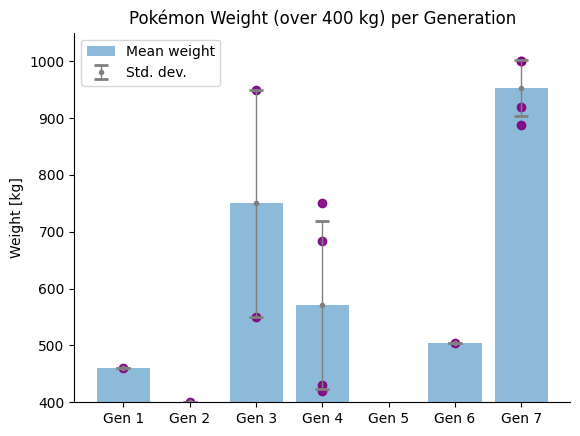

In [ ]:

# Function to filter Pokémon that are 400 kg or more
def filter_heavy_pokemon(gen_weights, max_weight=400):
    return {gen: [weight for weight in weights if weight >= max_weight] for gen, weights in gen_weights.items()}


# Filter Pokémon
filtered_gen_weights = filter_heavy_pokemon(gen_weights)
filtered_gen_weights["5"] = []  # If no Pokémon in Gen 5 meet criteria, use empty list

# Compute mean weights per generation
heavy_means = [find_mean(filtered_gen_weights[str(i)]) for i in range(1, 8)]

# Compute standard deviations 
heavy_stdevs = [find_stdev(filtered_gen_weights[str(i)]) for i in range(1, 8)]

# X-axis labels
x_vals = [f'Gen {i}' for i in range(1, 8)]

# Plot bar chart of mean weights
plt.bar(x_vals, heavy_means, alpha=.5, label = "Mean weight")

# Error bar showing the standard deviation of the mean    
plt.errorbar(x_vals, heavy_means, yerr=heavy_stdevs, fmt='.', capsize=5, capthick=2, elinewidth=1, color="gray", label="Std. dev.")

# Scatter plot of all Pokémon weights per generation
for i in range(1, 8):
    plt.scatter([f'Gen {i}' for _ in filtered_gen_weights[str(i)]], filtered_gen_weights[str(i)], color="purple", alpha=.9)


# Customization
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(400, 1050)
plt.ylabel("Weight [kg]")
plt.title("Pokémon Weight (over 400 kg) per Generation")
plt.legend()



This plot only considers the Pokémon over 400 kg. Here it is clear that Gen 7 has the heaviest Pokémon, with Gen 3 being the generation with the second heaviest Pokémon.

## Total Weight

Text(0.5, 1.0, 'Total Pokémon Weight Distribution by Generation')

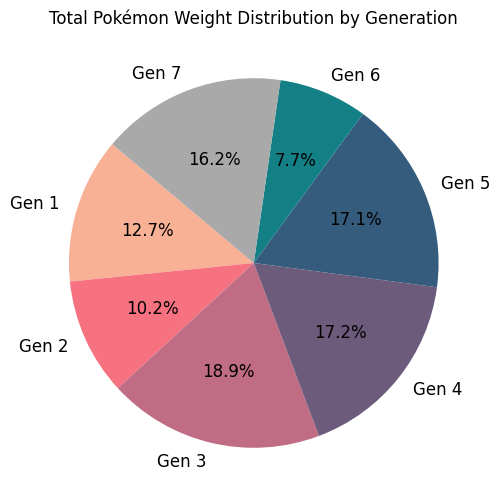

In [157]:
# Makes dictionary to with the total weights of each generation
total_weights = {gen: sum(weights) for gen, weights in gen_weights.items()}
# Define custom color palette with grey and purple tones
colors = ["#F8B195", "#F67280", "#C06C84", "#6C5B7B", "#355C7D", "#138086", "#a9a9a9"]
    
# Extracting labels and values for the pie chart
labels = [f'Gen {i}' for i in range(1, 8)]
values = list(total_weights.values())

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 12}, startangle=140, colors=colors)
plt.title("Total Pokémon Weight Distribution by Generation")



The pie chart above does not give us a lot of information except that Gen 6 has both a low total weight and a low average weight. Otherwise the total amout of Pokémon seems to be quite similar.